# Most Popular Movies Analysis

## Section 1: EDA

### Griffin Brown

This project serves as a fun analysis of the most popular movies on the popular website, TMDB. It will showcase my skills in python, with a focus on EDA and data analysis with some prediction at the end. I chose this dataset because it is easy to understand, and who doesn't like movies?

## TOC
* [Section 1](#section1)
    * [Data Loading](#data-loading)
    * [Quick Facts](#quick-facts)
    * [Genres](#genres)
        * [Comedy](#comedy)
    * [Distribution](#distribution)
* [Section 2](#section2)
    * [Feature Engineering](#feature-engineering)
    * [Preparing For Testing](#preparing)
    * Models
        * [LightGBM](#lightgbm)
        * [XGBoost](#xgboost)
        * [Random Forest](#random-forest)
        * [Simple Tree](#simple-tree)
        * [Linear Regression](#linear-regression)
        * [KNN](#knn)
    * [Model Metrics](#model-metrics)


## Data Loading <a class="anchor" id="data-loading"></a>

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import seaborn as sns

# Turn off scientific notation
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
np.set_printoptions(suppress=True)

In [347]:
# file stored in public accessible bigquery bucket
movies_url = 'https://storage.googleapis.com/data-projects/top_1000_popular_movies_tmdb.csv'

movies = pd.read_csv(movies_url, lineterminator='\n')

movies.shape

(10001, 15)

In [348]:
movies.head()

,Unnamed: 0,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline\r
0,0,385687,Fast X,5/17/2023,"['Action', 'Crime', 'Thriller']",English,7.40,"1,347.00","8,363.47",Over many missions and against impossible odds...,"340,000,000.00","['Universal Pictures', 'Original Film', 'One R...","652,000,000.00",142.00,The end of the road begins.\r
1,1,603692,John Wick: Chapter 4,3/22/2023,"['Action', 'Thriller', 'Crime']",English,7.90,"2,896.00","4,210.31","With the price on his head ever increasing, Jo...","90,000,000.00","['Thunder Road', '87Eleven', 'Summit Entertain...","431,769,198.00",170.00,"No way back, one way out.\r"
2,2,502356,The Super Mario Bros. Movie,4/5/2023,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.80,"4,628.00","3,394.46","While working underground to fix a water main,...","100,000,000.00","['Universal Pictures', 'Illumination', 'Ninten...","1,308,766,975.00",92.00,\r
3,3,569094,Spider-Man: Across the Spider-Verse,5/31/2023,"['Action', 'Adventure', 'Animation', 'Science ...",English,8.80,"1,160.00","2,859.05","After reuniting with Gwen Stacy, Brooklyn’s fu...","100,000,000.00","['Columbia Pictures', 'Sony Pictures Animation...","313,522,201.00",140.00,It's how you wear the mask that matters\r
4,4,536437,Hypnotic,5/11/2023,"['Mystery', 'Thriller', 'Science Fiction']",English,6.50,154.00,"2,654.85",A detective becomes entangled in a mystery inv...,"70,000,000.00","['Studio 8', 'Solstice Productions', 'Ingeniou...",0.00,94.00,Control is an illusion.\r


In [349]:
# unnecessary first column
movies = movies.drop(movies.columns[0], axis=1)

In [350]:
movies.describe()

,id,vote_average,vote_count,popularity,budget,revenue,runtime
count,"10,001.00","10,000.00","10,000.00","10,000.00","9,999.00","9,999.00","9,999.00"
mean,"300,146.50",6.32,"1,558.29",33.54,"19,937,995.59","60,843,365.57",100.81
std,"337,990.06",1.46,"2,887.86",126.50,"38,705,817.98","155,307,273.36",27.85
min,0.00,0.00,0.00,12.30,0.00,0.00,0.00
25%,"11,504.00",5.90,143.00,14.60,0.00,0.00,90.00
50%,"118,406.00",6.60,519.00,18.58,"1,250,000.00","2,133,452.00",100.00
75%,"537,915.00",7.10,"1,584.00",28.01,"23,000,000.00","51,062,297.00",115.00
max,"1,136,631.00",10.00,"33,822.00","8,363.47","460,000,000.00","2,923,706,026.00",366.00


One thing that sticks out to me is how absurdly long the longest runtime is.

In [351]:
longest_movie = movies.loc[movies['runtime'].idxmax()]
longest_movie

id                                                                  11659
title                                                   The Best of Youth
release_date                                                    6/22/2003
genres                                    ['Drama', 'History', 'Romance']
original_language                                                 Italian
vote_average                                                         8.10
vote_count                                                         465.00
popularity                                                          13.48
overview                Spanning nearly four decades, this generationa...
budget                                                               0.00
production_companies                         ['BiBi Film', 'Rai Fiction']
revenue                                                      2,693,053.00
runtime                                                            366.00
tagline\r                             

## Quick Facts <a class="anchor" id="quick-facts"></a>

In [352]:
# adding some features
movies['net_revenue'] = movies['revenue'] - movies['budget']
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies = movies.dropna(subset=['release_date'])
movies['year'] = movies['release_date'].dt.year

In [353]:
# top movies by total net revenue
highest_net_revenue_5 = movies.nlargest(5, 'net_revenue').sort_values(by='net_revenue')

# some movies have not come out yet, need to make sure to not include these as they have no revenue
lowest_net_revenue_5 = movies.loc[movies['revenue'] > 0].nsmallest(5, 'net_revenue')

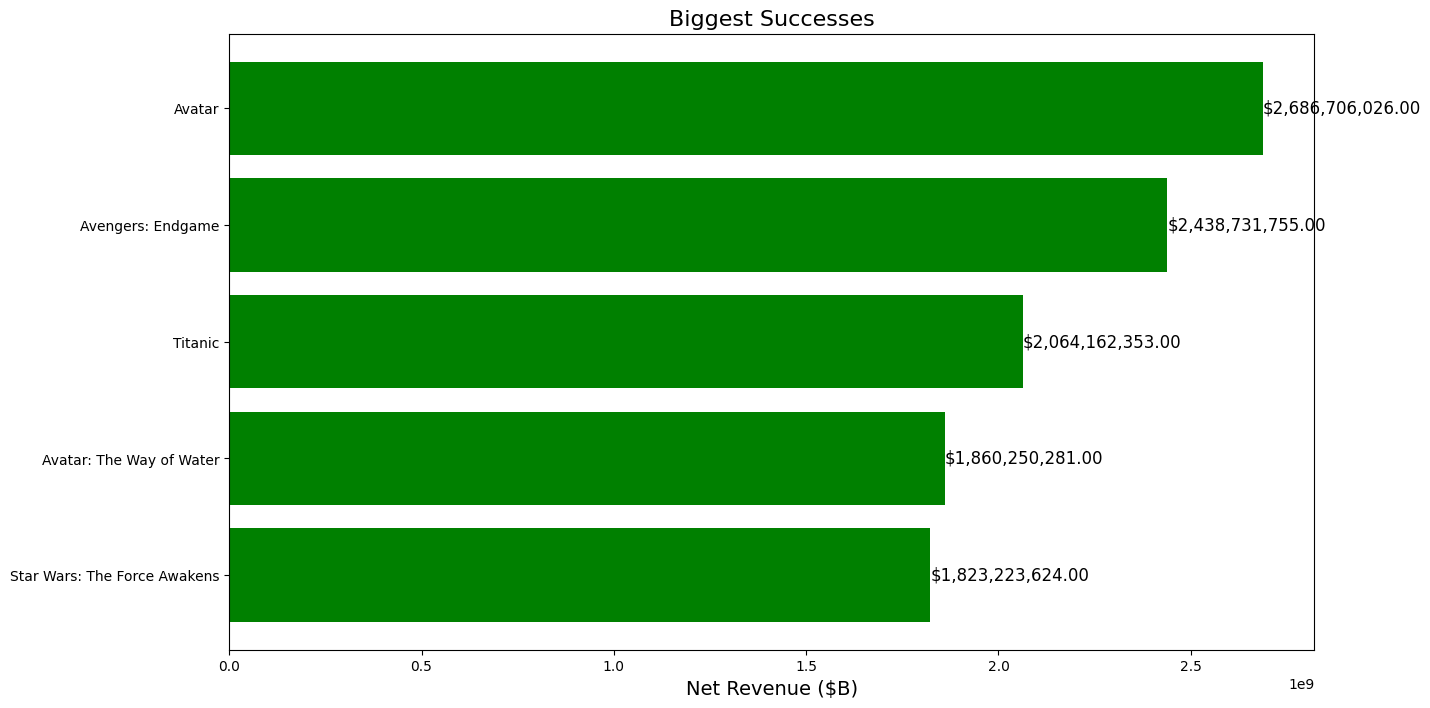

In [354]:
titles = highest_net_revenue_5['title'].tolist()
revenues = highest_net_revenue_5['net_revenue'].to_list()
colors = ['green'] * 5 
fig = plt.figure(figsize=(14, 8))
bars = plt.barh(titles, revenues, color=colors)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'${width:,.2f}', ha='left', va='center', fontsize=12)
plt.title('Biggest Successes', fontsize=16)
plt.xlabel('Net Revenue ($B)', fontsize=14)
plt.show()

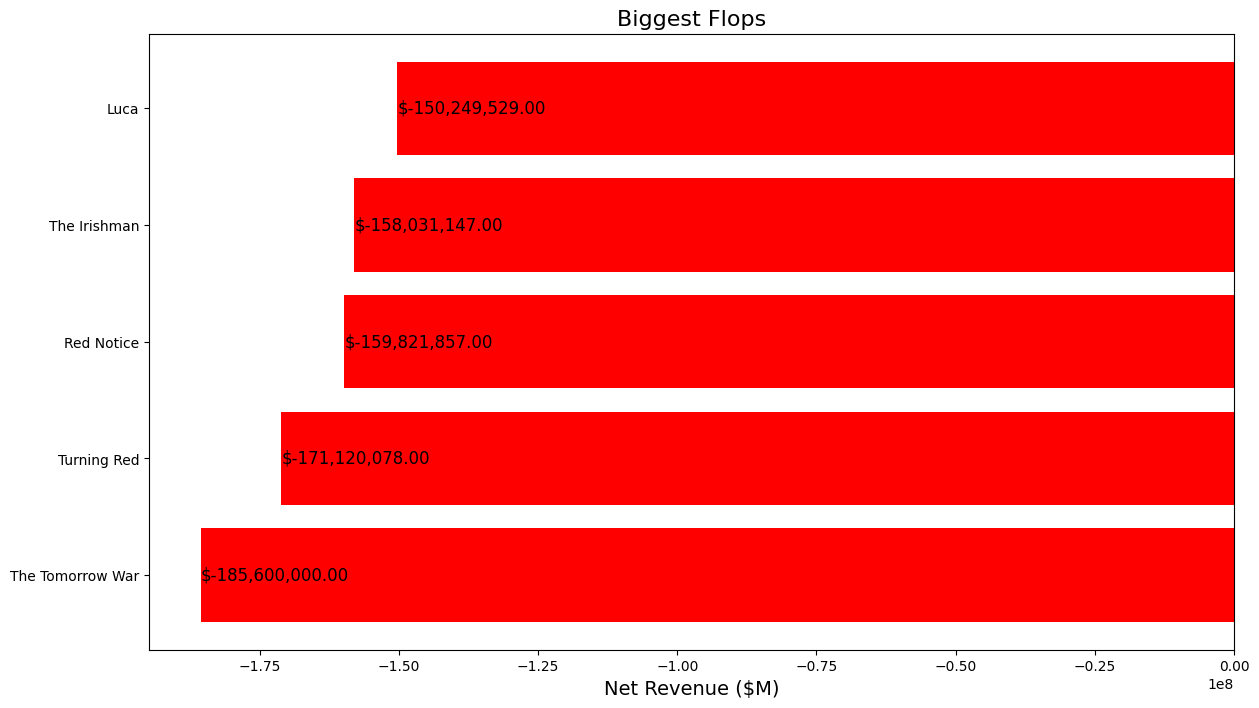

In [355]:
titles = lowest_net_revenue_5['title'].tolist()
revenues = lowest_net_revenue_5['net_revenue'].to_list()
colors = ['red'] * 5 
fig = plt.figure(figsize=(14, 8))
bars = plt.barh(titles, revenues, color=colors)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'${width:,.2f}', ha='left', va='center', fontsize=12)
plt.title('Biggest Flops', fontsize=16)
plt.xlabel('Net Revenue ($M)', fontsize=14)
plt.show()

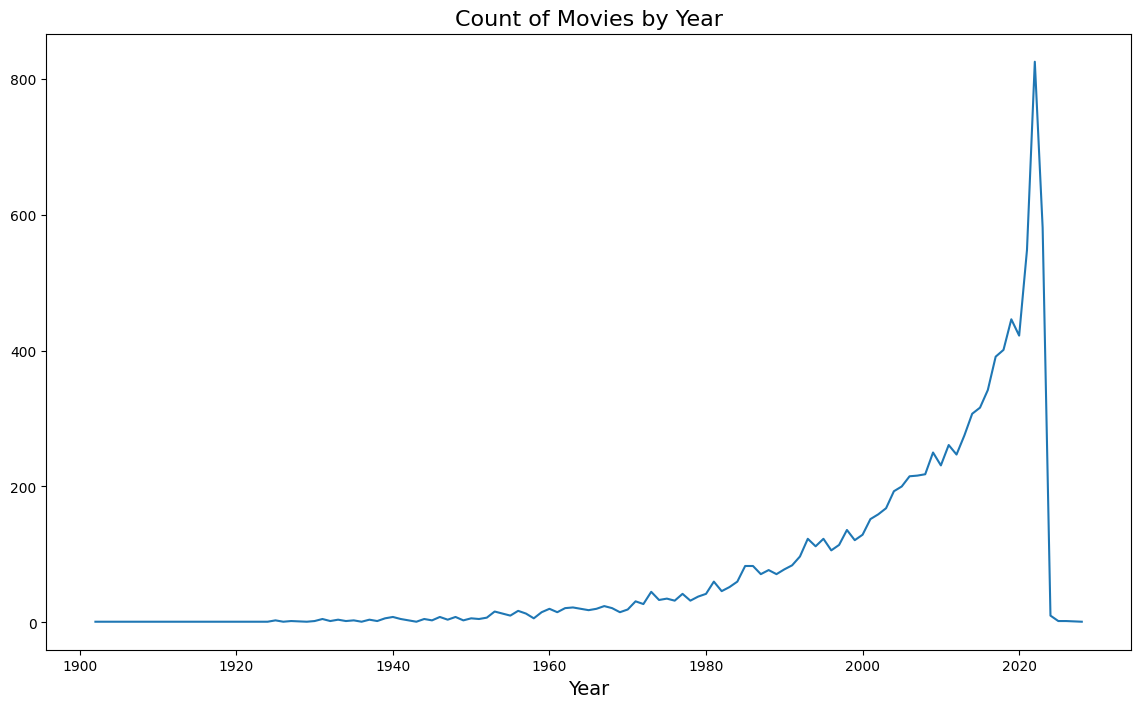

In [356]:
year_counts = movies['year'].value_counts().reset_index()
year_counts.columns = ['year', 'counts']
year_counts = year_counts.sort_values(by='year')
plt.figure(figsize=(14,8))
plt.plot(year_counts['year'], year_counts['counts'])
plt.title('Count of Movies by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.show()

To probably no ones surprise, the amount of movies has been climbing year over year. Since this dataset was published midway through 2023, let's filter our data from 1960-2022 for a more full set.

In [357]:
movies = movies[(movies['year'] <= 2022) & (movies['year'] >= 1960)]

## Genres <a class="anchor" id="genres"></a>

Let's first have a look at the most popular genres in this dataset. We'll have to explode the genres column since most are listed as many values, which will lead to duplicates, but we just want to explore the trends.

In [358]:
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
genre_explode = movies.explode('genres')
genre_explode.shape

(24159, 16)

In [359]:
genre_counts = genre_explode['genres'].value_counts().reset_index()
genre_counts.columns = ['genres', 'counts']
genre_counts = genre_counts[genre_counts['genres']!=178]
genre_counts['genres'] = genre_counts['genres'].astype(str)
genre_counts = pd.DataFrame(genre_counts).sort_values(by='counts')
genre_counts_10 = genre_counts.nlargest(5, 'counts')

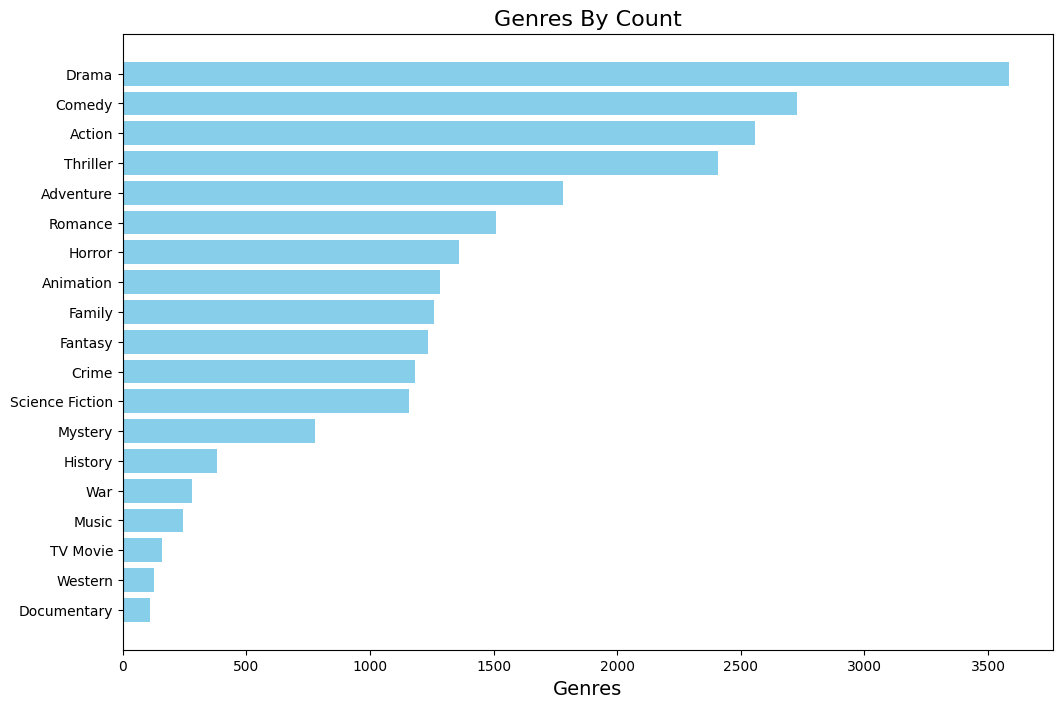

In [360]:
genres = genre_counts['genres'].to_list()
counts = genre_counts['counts'].to_list()
plt.figure(figsize=(12, 8))
bars = plt.barh(genres, counts, color='skyblue')
plt.title('Genres By Count', fontsize=16)
plt.xlabel('Genres', fontsize=14)
plt.show()

In [361]:
genre_year_counts = genre_explode.groupby(['year', 'genres']).size().reset_index(name='counts')
genre_year_counts.columns = ['year', 'genres', 'counts']
pivot_data = genre_year_counts.pivot(index='year', columns='genres', values='counts')
top_genres = genre_counts_10['genres'].tolist()
filtered_data = pivot_data[top_genres]

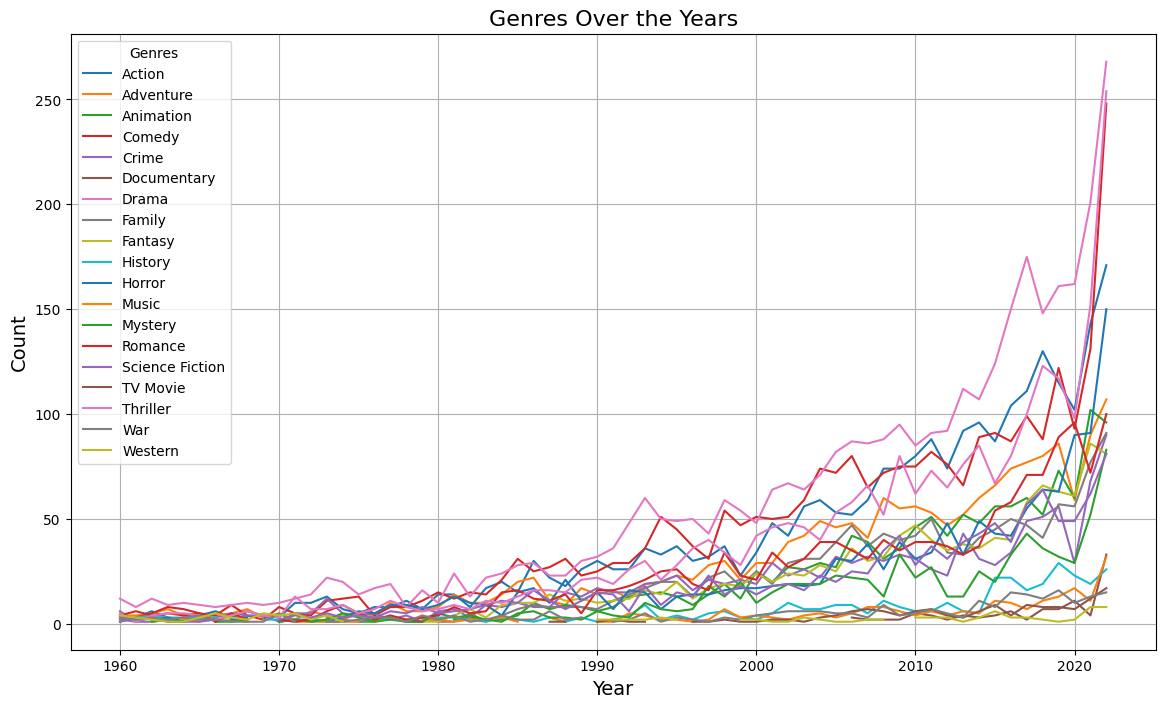

In [362]:
plt.figure(figsize=(14, 8))
for genre in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[genre], label=genre)
plt.title('Genres Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Genres')
plt.grid(True)
plt.show()

Yikes, that's a bit too much to look at. Let's look at the top 5 genres and see if we can derive any insights.

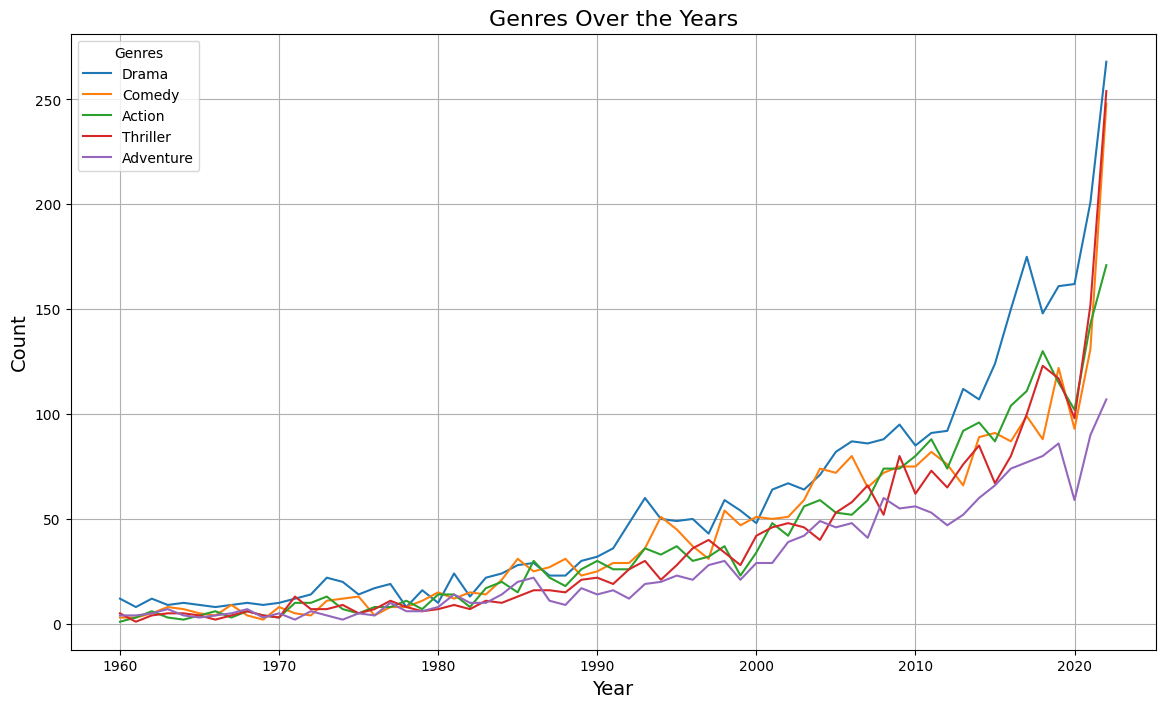

In [363]:
plt.figure(figsize=(14, 8))
for genre in top_genres:
    plt.plot(filtered_data.index, filtered_data[genre], label=genre)
plt.title('Genres Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Genres')
plt.grid(True)
plt.show()

That's a bit better. Something I find interesting is that Comedy is still a very popular movie genre. In my opinion, comedy movies aren't what they used to be. Let's look into whether comedy is actually getting better or not. 

### Comedy <a class="anchor" id="comedy"></a>

In [364]:
comedy_movies = genre_explode[genre_explode['genres'] == 'Comedy']
comedy_vote_average_by_year = comedy_movies.groupby('year')['vote_average'].mean().reset_index()
comedy_vote_average_by_year.columns = ['year', 'vote_average']
comedy_vote_average_by_year =pd.DataFrame(comedy_vote_average_by_year).sort_values(by='year')

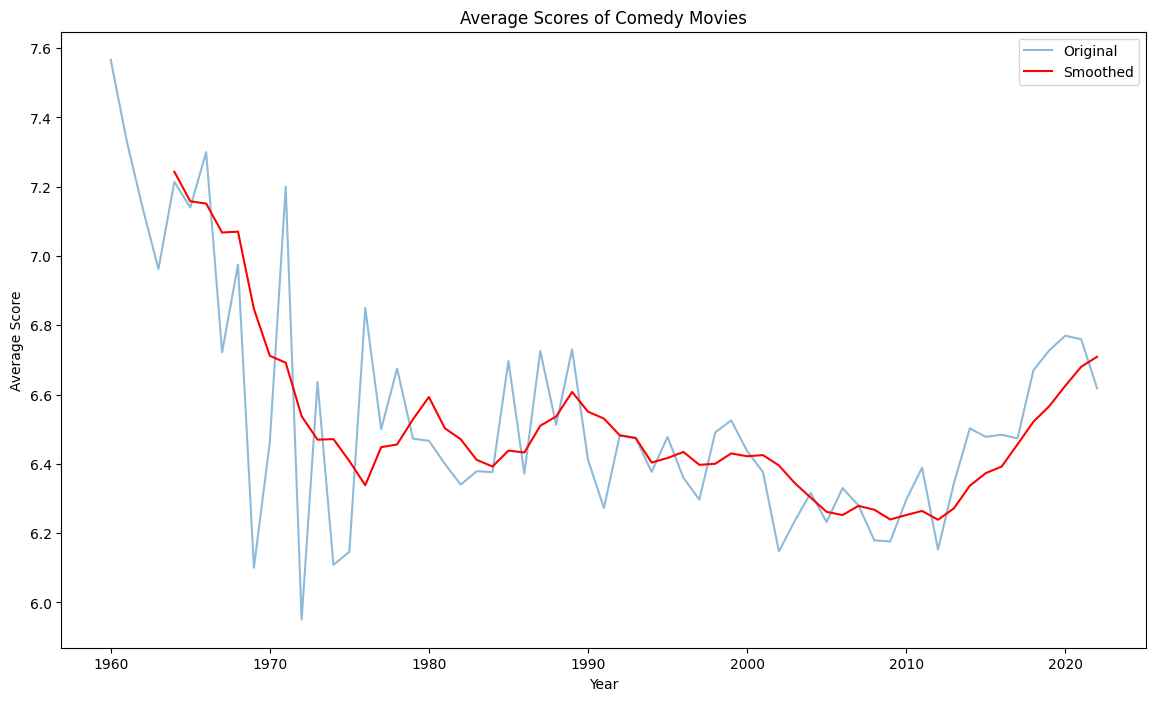

In [365]:
comedy_vote_average_by_year['smoothed_vote_average'] = comedy_vote_average_by_year['vote_average'].rolling(window=5).mean()

plt.figure(figsize=(14,8))
plt.plot(comedy_vote_average_by_year['year'], comedy_vote_average_by_year['vote_average'], alpha=0.5, label='Original')
plt.plot(comedy_vote_average_by_year['year'], comedy_vote_average_by_year['smoothed_vote_average'], label='Smoothed', color='red')
plt.title('Average Scores of Comedy Movies')
plt.ylabel('Average Score')
plt.xlabel('Year')
plt.legend()
plt.show()

Let's compare these scores with movies overall.

In [366]:
vote_average_by_year = movies.groupby('year')['vote_average'].mean().reset_index()
vote_average_by_year.columns = ['year', 'vote_average']
vote_average_by_year = pd.DataFrame(vote_average_by_year).sort_values(by='year')

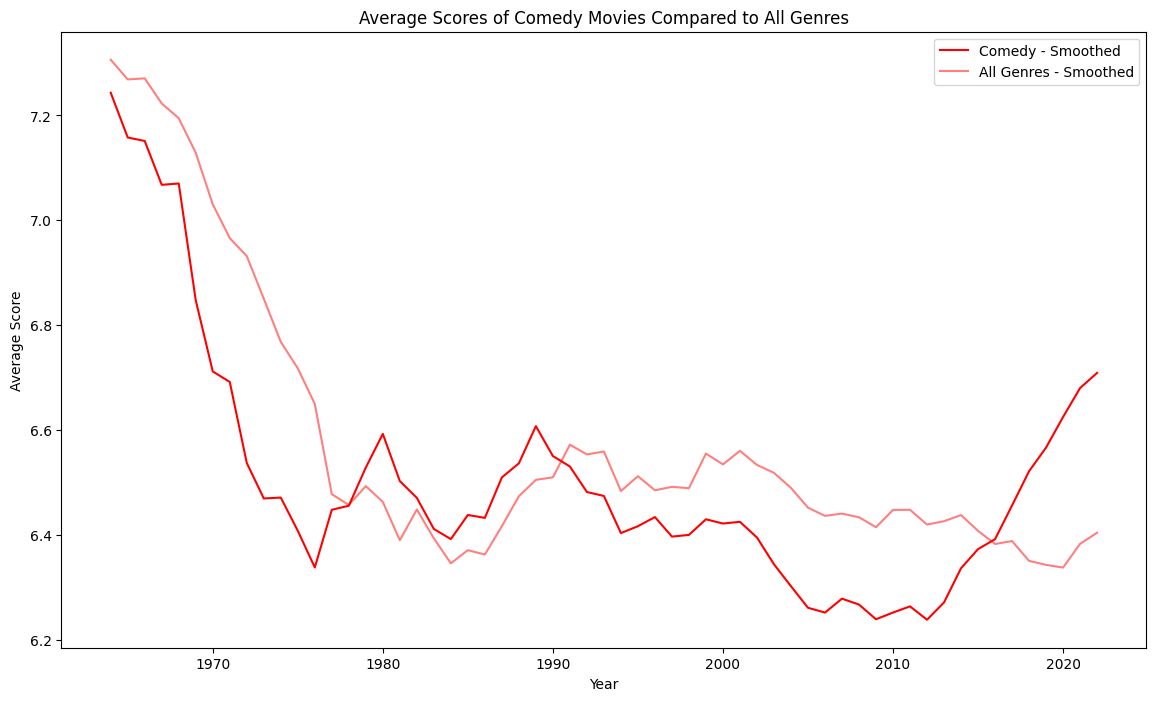

In [367]:
vote_average_by_year['smoothed_vote_average'] = vote_average_by_year['vote_average'].rolling(window=5).mean()

plt.figure(figsize=(14,8))
plt.plot(comedy_vote_average_by_year['year'], comedy_vote_average_by_year['smoothed_vote_average'], label='Comedy - Smoothed', color='red')
plt.plot(vote_average_by_year['year'], vote_average_by_year['smoothed_vote_average'], label='All Genres - Smoothed', color='red', alpha=0.5)
plt.title('Average Scores of Comedy Movies Compared to All Genres')
plt.ylabel('Average Score')
plt.xlabel('Year')
plt.legend()
plt.show()

Well, that's note exactly what I thought would be the case. Apparently, Comedy is on average scoring a lot better than all genres on average.

## Distribution

A look at the distribution of our target variable.

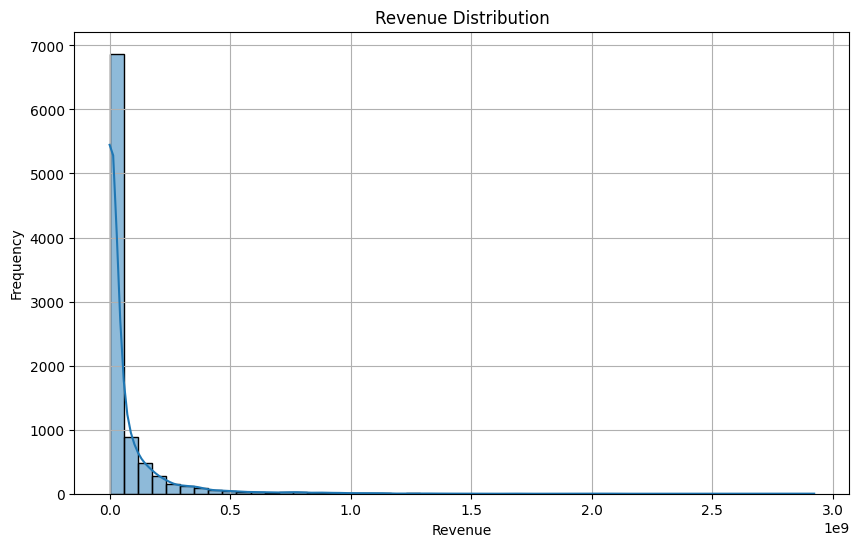

In [368]:
plt.figure(figsize=(10, 6))
sns.histplot(movies['revenue'], bins=50, kde=True)
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Very skewed, will want to look deeper into this.

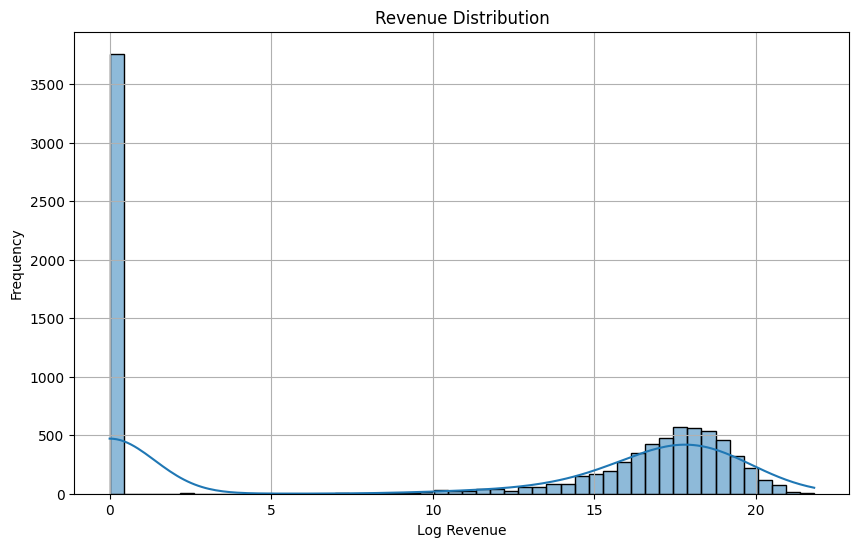

In [369]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(movies['revenue']), bins=50, kde=True)
plt.title('Revenue Distribution')
plt.xlabel('Log Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [370]:
count_zero_revenue = (movies['revenue']==0).sum()
print(count_zero_revenue)

3761


Seems like way too many movies with 0 revenue, will most likely just filter these out. With such a 

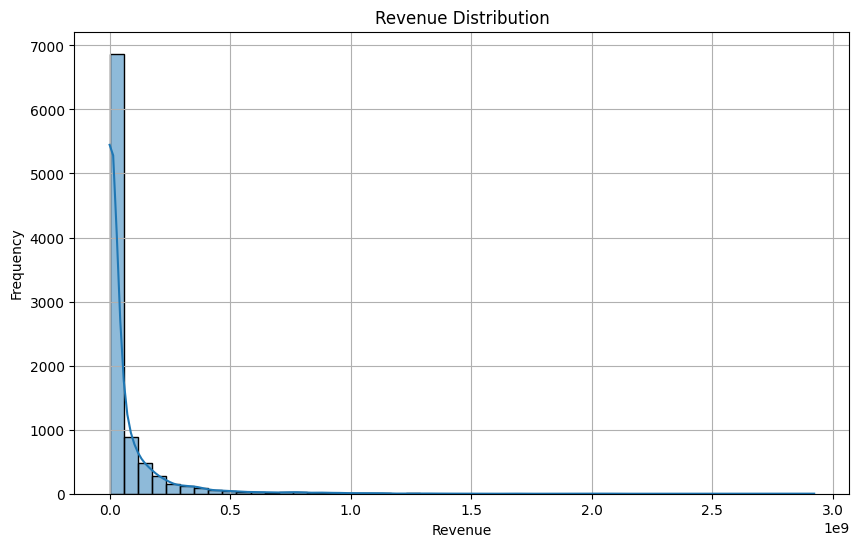

In [371]:
plt.figure(figsize=(10, 6))
sns.histplot(movies['revenue'], bins=50, kde=True)
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

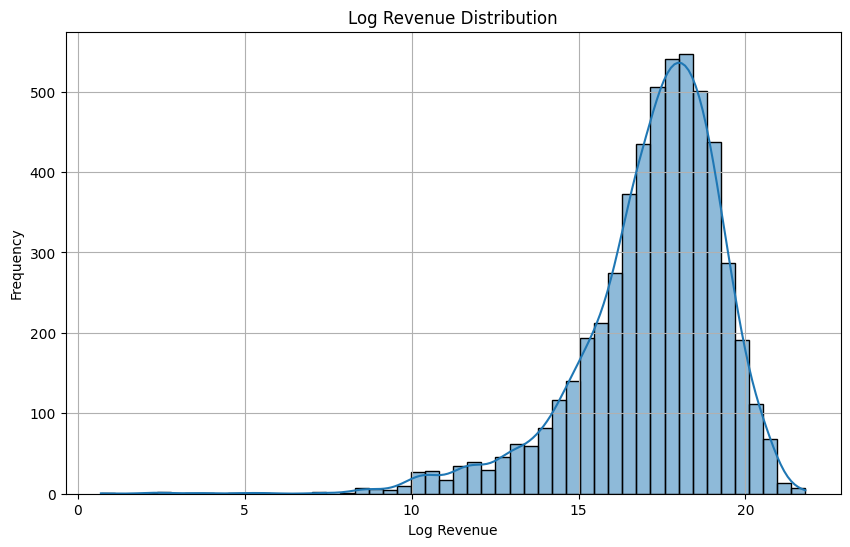

In [372]:
movies = movies[movies['revenue'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(movies['revenue']), bins=50, kde=True)
plt.title('Log Revenue Distribution')
plt.xlabel('Log Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Notes

Mid-Development/EDA: 1.5 Hours

# Section 2: Revenue Prediction <a class="anchor" id="section2"></a>

In [373]:
df = pd.read_csv(movies_url, lineterminator='\n')
df = df.drop(df.columns[0], axis=1)
df.head()

,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline\r
0,385687,Fast X,5/17/2023,"['Action', 'Crime', 'Thriller']",English,7.40,"1,347.00","8,363.47",Over many missions and against impossible odds...,"340,000,000.00","['Universal Pictures', 'Original Film', 'One R...","652,000,000.00",142.00,The end of the road begins.\r
1,603692,John Wick: Chapter 4,3/22/2023,"['Action', 'Thriller', 'Crime']",English,7.90,"2,896.00","4,210.31","With the price on his head ever increasing, Jo...","90,000,000.00","['Thunder Road', '87Eleven', 'Summit Entertain...","431,769,198.00",170.00,"No way back, one way out.\r"
2,502356,The Super Mario Bros. Movie,4/5/2023,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.80,"4,628.00","3,394.46","While working underground to fix a water main,...","100,000,000.00","['Universal Pictures', 'Illumination', 'Ninten...","1,308,766,975.00",92.00,\r
3,569094,Spider-Man: Across the Spider-Verse,5/31/2023,"['Action', 'Adventure', 'Animation', 'Science ...",English,8.80,"1,160.00","2,859.05","After reuniting with Gwen Stacy, Brooklyn’s fu...","100,000,000.00","['Columbia Pictures', 'Sony Pictures Animation...","313,522,201.00",140.00,It's how you wear the mask that matters\r
4,536437,Hypnotic,5/11/2023,"['Mystery', 'Thriller', 'Science Fiction']",English,6.50,154.00,"2,654.85",A detective becomes entangled in a mystery inv...,"70,000,000.00","['Studio 8', 'Solstice Productions', 'Ingeniou...",0.00,94.00,Control is an illusion.\r


### Feature Engineering <a class="anchor" id="feature-engineering"></a>

In [374]:
# don't want these
dropped_columns = ['id', 'title', 'overview', 'tagline\r', 'production_companies']
kept_columns = [col for col in df.columns if col not in dropped_columns]
df = df[kept_columns]

# want any film with a revenue above 0
df = df[df['revenue'] > 0]

# feature engineering
df['budget_to_rating'] = df['budget']/(df['vote_average']+1)
df['budget_to_pop'] = df['budget']/df['popularity']
df['budget_to_vote_count'] = df['budget'] / (df['vote_count'] + 1)
df['vote_count_to_popularity'] = df['vote_count'] / (df['popularity'] + 1)
#df['budget_squared'] = df['budget'] ** 2
df['vote_average_squared'] = df['vote_average'] ** 2
df['log_budget'] = np.log1p(df['budget'])

# dates
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_day_of_week'] = df['release_date'].dt.dayofweek
df['release_quarter'] = df['release_date'].dt.quarter
df = df.dropna(subset=['release_date'])
df['year'] = df['release_date'].dt.year
df['month'] = df['release_date'].dt.month
df = df.drop(['release_date'], axis=1)
df.head()

# Normalized Features
df['normalized_vote_count'] = (df['vote_count'] - df['vote_count'].mean()) / df['vote_count'].std()
df['normalized_popularity'] = (df['popularity'] - df['popularity'].mean()) / df['popularity'].std()
df['normalized_runtime'] = (df['runtime'] - df['runtime'].mean()) / df['runtime'].std()

# Interactions and Ratios
df['popularity_per_vote'] = df['popularity'] / (df['vote_count'] + 1)
df['vote_count_per_runtime'] = df['vote_count'] / (df['runtime'] + 1)
df['popularity_per_runtime'] = df['popularity'] / (df['runtime'] + 1)

# Aggregated and Statistical Features
df['mean_vote_count_per_year'] = df.groupby('year')['vote_count'].transform('mean')
df['median_popularity_per_year'] = df.groupby('year')['popularity'].transform('median')

# Temporal Features
df['release_year_average_vote'] = df.groupby('year')['vote_average'].transform('mean')

# Binned Features
df['runtime_category'] = pd.cut(df['runtime'], bins=[0, 90, 120, np.inf], labels=['short', 'medium', 'long'])
df['vote_average_bin'] = pd.cut(df['vote_average'], bins=[0, 5, 7, 10], labels=['low', 'medium', 'high'])

# Log Transformations
df['log_vote_count'] = np.log1p(df['vote_count'])
df['log_popularity'] = np.log1p(df['popularity'])
df['log_runtime'] = np.log1p(df['runtime'])

""" # Percentage Change
df = df.sort_values(by=['year', 'month'])
df['pct_change_popularity'] = df['popularity'].pct_change().fillna(0)
df['pct_change_runtime'] = df['runtime'].pct_change().fillna(0)

# Ranking Features
df['rank_popularity'] = df['popularity'].rank()
df['rank_vote_count'] = df['vote_count'].rank() """
 
df.head()

,genres,original_language,vote_average,vote_count,popularity,budget,revenue,runtime,budget_to_rating,budget_to_pop,...,vote_count_per_runtime,popularity_per_runtime,mean_vote_count_per_year,median_popularity_per_year,release_year_average_vote,runtime_category,vote_average_bin,log_vote_count,log_popularity,log_runtime
0,"['Action', 'Crime', 'Thriller']",English,7.40,"1,347.00","8,363.47","340,000,000.00","652,000,000.00",142.00,"40,476,190.48","40,652.97",...,9.42,58.49,632.05,131.83,6.58,long,high,7.21,9.03,4.96
1,"['Action', 'Thriller', 'Crime']",English,7.90,"2,896.00","4,210.31","90,000,000.00","431,769,198.00",170.00,"10,112,359.55","21,376.08",...,16.94,24.62,632.05,131.83,6.58,long,high,7.97,8.35,5.14
2,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.80,"4,628.00","3,394.46","100,000,000.00","1,308,766,975.00",92.00,"11,363,636.36","29,459.78",...,49.76,36.50,632.05,131.83,6.58,medium,high,8.44,8.13,4.53
3,"['Action', 'Adventure', 'Animation', 'Science ...",English,8.80,"1,160.00","2,859.05","100,000,000.00","313,522,201.00",140.00,"10,204,081.63","34,976.69",...,8.23,20.28,632.05,131.83,6.58,long,high,7.06,7.96,4.95
5,"['Action', 'Adventure', 'Science Fiction']",English,7.40,195.00,"2,453.81","200,000,000.00","171,045,464.00",127.00,"23,809,523.81","81,506.00",...,1.52,19.17,632.05,131.83,6.58,long,high,5.28,7.81,4.85


In [375]:
df.shape[0]

5604

Let's make sure we don't have any weird values, like infinity, in the dataset that will mess up the predictions.

In [376]:
max_values = df.max()

min_values = df.min()

extremes_df = pd.DataFrame({
    'Max': max_values,
    'Min': min_values
})

extremes_df

,Max,Min
genres,['Western'],"['Action', 'Adventure', 'Animation', 'Comedy',..."
original_language,cn,Arabic
vote_average,8.80,0.00
vote_count,"33,822.00",0.00
popularity,"8,363.47",12.30
budget,"460,000,000.00",0.00
revenue,"2,923,706,026.00",1.00
runtime,366.00,4.00
budget_to_rating,"52,873,563.22",0.00
budget_to_pop,"15,524,334.39",0.00


In [377]:
#df = df[df['original_language'] == 'English']

def safe_eval(val):
    if isinstance(val, str):
        return eval(val)
    return []

df['genres'] = df['genres'].apply(safe_eval)

mlb_genres = MultiLabelBinarizer()

# One-hot encode genres
genres_encoded = mlb_genres.fit_transform(df['genres'])
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb_genres.classes_)

df = df.drop(['genres'], axis=1)
df = pd.concat([df, genres_encoded_df], axis=1)
df.head()


,original_language,vote_average,vote_count,popularity,budget,revenue,runtime,budget_to_rating,budget_to_pop,budget_to_vote_count,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,English,7.40,"1,347.00","8,363.47","340,000,000.00","652,000,000.00",142.00,"40,476,190.48","40,652.97","252,225.52",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,English,7.90,"2,896.00","4,210.31","90,000,000.00","431,769,198.00",170.00,"10,112,359.55","21,376.08","31,066.62",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,English,7.80,"4,628.00","3,394.46","100,000,000.00","1,308,766,975.00",92.00,"11,363,636.36","29,459.78","21,602.94",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,English,8.80,"1,160.00","2,859.05","100,000,000.00","313,522,201.00",140.00,"10,204,081.63","34,976.69","86,132.64",...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
5,English,7.40,195.00,"2,453.81","200,000,000.00","171,045,464.00",127.00,"23,809,523.81","81,506.00","1,020,408.16",...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [378]:
def preprocess_dataframe(df):
    object_cols = df.select_dtypes(include='object').columns.to_list()
    for col in object_cols:
        df[col] = df[col].astype('category')

    category_cols = [col for col in df.columns if df[col].dtype == 'category']

    for col in category_cols:
        df[col], _ = pd.factorize(df[col])

    for col in category_cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

    return df

In [379]:
df.shape

(7851, 50)

In [380]:
preprocess_dataframe(df)
df.head()

,original_language,vote_average,vote_count,popularity,budget,revenue,runtime,budget_to_rating,budget_to_pop,budget_to_vote_count,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,7.40,"1,347.00","8,363.47","340,000,000.00","652,000,000.00",142.00,"40,476,190.48","40,652.97","252,225.52",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,0,7.90,"2,896.00","4,210.31","90,000,000.00","431,769,198.00",170.00,"10,112,359.55","21,376.08","31,066.62",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0,7.80,"4,628.00","3,394.46","100,000,000.00","1,308,766,975.00",92.00,"11,363,636.36","29,459.78","21,602.94",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0,8.80,"1,160.00","2,859.05","100,000,000.00","313,522,201.00",140.00,"10,204,081.63","34,976.69","86,132.64",...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
5,0,7.40,195.00,"2,453.81","200,000,000.00","171,045,464.00",127.00,"23,809,523.81","81,506.00","1,020,408.16",...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [381]:
total_nan_count = df['revenue'].isna().sum()
total_nan_count

2247

### Preparing For Testing <a class="anchor" id="preparing"></a>

In [382]:
df_cleaned = df.dropna()
y = df_cleaned['revenue']
X = df_cleaned.drop(['revenue'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

### LightGBM <a class="anchor" id="lightgbm"></a>

In [383]:

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lgbm_params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'learning_rate': 0.01, 
          'num_leaves': 48, 
          'num_iteration': 200, 
          'verbose': 0 ,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth': 8, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1
          }

lgbm = lgb.train(lgbm_params, 
                train_data, 
                num_boost_round=1000, 
                valid_sets=[train_data, test_data]) 
                #early_stopping_rounds=100

lgbm_y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

c:\Users\gbrown\OneDrive - uolf.org\Desktop\Masters\movie_analysis\.venv\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [384]:
def get_metrics(y_test, test_pred):
    metrics = {
        'R-squared (R²)': r2_score(y_test, test_pred),
        'Mean Absolute Error (MAE)': mean_absolute_error(y_test, test_pred),
        #'Mean Squared Error (MSE)': mean_squared_error(y_test, test_pred),
        #'Root Mean Squared Error (RMSE)': mean_squared_error(y_test, test_pred, squared=False),
        'Mean Absolute Percentage Error (MAPE)': np.mean(np.abs((y_test - test_pred) / y_test)) * 100,
        'Median Absolute Error': median_absolute_error(y_test, test_pred)
    }
    return metrics

metrics_df = pd.DataFrame()

lgbm_metrics = get_metrics(y_test, lgbm_y_pred)
lgbm_metrics_df = pd.DataFrame(lgbm_metrics, index=['LightGBM'])

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

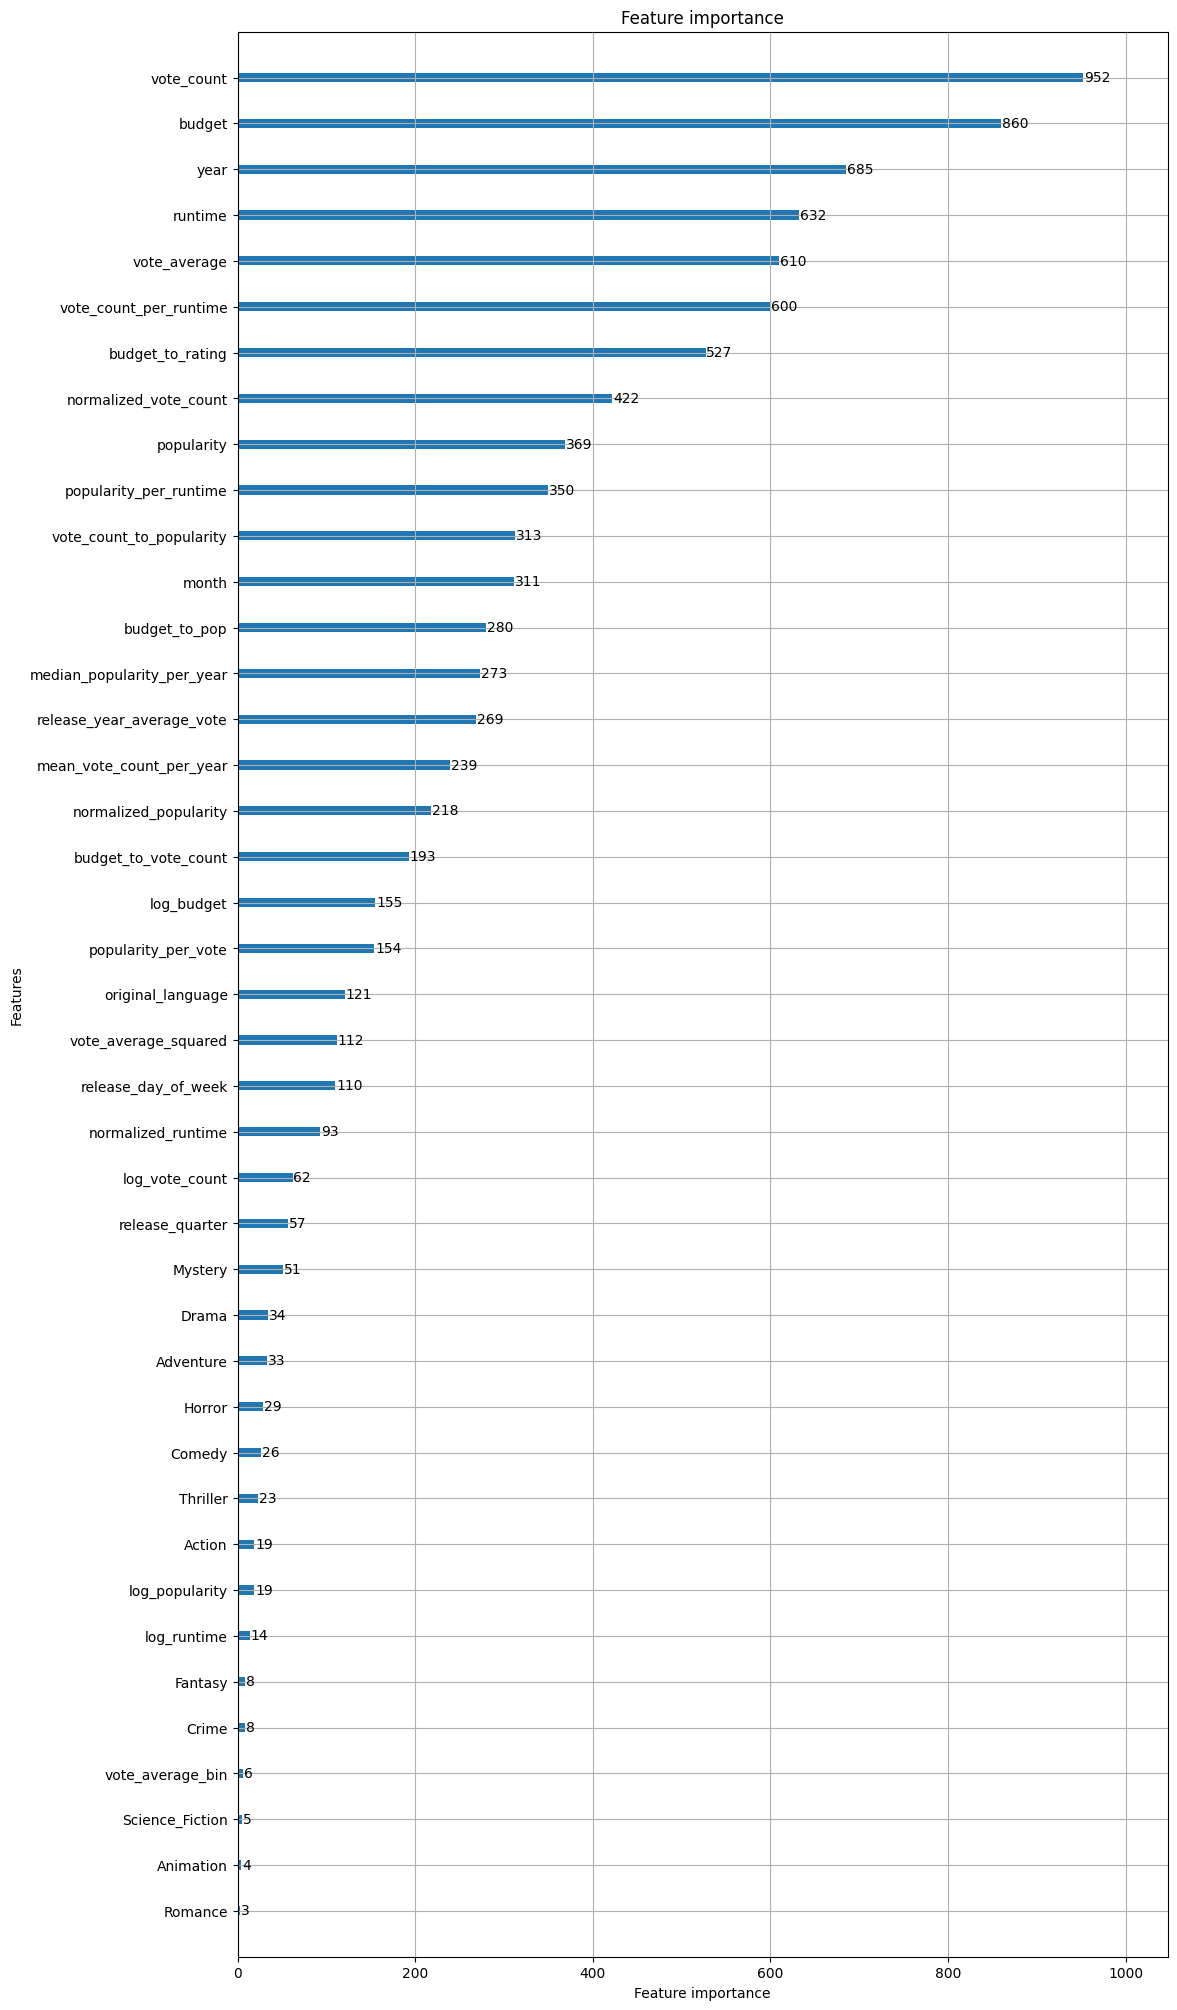

In [385]:
lgb.plot_importance(lgbm, figsize=(12,25))

### XGBoost <a class="anchor" id="xgboost"></a>

In [386]:
# Convert the training and testing sets into DMatrix format
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
} 

xgb_model = xgb.train(
    params=xgb_params,
    dtrain=train_data,
    num_boost_round=1000,
    evals=[(train_data, 'train'), (test_data, 'eval')],
    early_stopping_rounds=100,
    verbose_eval=False
)

xgb_y_pred = xgb_model.predict(test_data)

In [387]:
xgb_metrics = get_metrics(y_test, xgb_y_pred)
xgb_metrics_df = pd.DataFrame(xgb_metrics, index=['XGBoost'])

### Random Forest <a class="anchor" id="random-forest"></a>

In [388]:
rf_params = {
    'n_estimators': 1000,
    'max_depth': 8,            
    'min_samples_split': 2,    
    'min_samples_leaf': 1,     
    'max_features': 'sqrt',    
    'bootstrap': True          
}

rf_model = rf(**rf_params, random_state=88)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_metrics = get_metrics(y_test, rf_y_pred)
rf_metrics_df = pd.DataFrame(rf_metrics, index=['Random Forest'])

### Simple Tree <a class="anchor" id="simple-tree"></a>

In [389]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

tree_y_pred = tree_model.predict(X_test)

tree_metrics = get_metrics(y_test, tree_y_pred)
tree_metrics_df = pd.DataFrame(tree_metrics, index=['Simple Tree'])


### Linear Regression <a class="anchor" id="linear-regression"></a>

In [390]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


lin_y_pred = linear_model.predict(X_test)

In [391]:
lin_metrics = get_metrics(y_test, lin_y_pred)
lin_metrics_df = pd.DataFrame(lin_metrics, index=['Linear Regression'])

### KNN <a class="anchor" id="knn"></a>

In [392]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)

In [393]:
knn_metrics = get_metrics(y_test, knn_y_pred)
knn_metrics_df = pd.DataFrame(knn_metrics, index=['KNN'])

### Model Metrics <a class="anchor" id="model-metrics"></a>

In [394]:
metrics_df = pd.concat([lgbm_metrics_df, xgb_metrics_df, rf_metrics_df, tree_metrics_df, lin_metrics_df, knn_metrics_df])
metrics_df.sort_values(by='R-squared (R²)', ascending=False)

,R-squared (R²),Mean Absolute Error (MAE),Mean Absolute Percentage Error (MAPE),Median Absolute Error
XGBoost,0.74,"72,160,298.93","52,602.78","36,043,137.50"
Random Forest,0.72,"73,355,792.97","151,972.73","41,220,057.59"
LightGBM,0.68,"77,518,194.08","341,797.97","43,668,585.03"
Linear Regression,0.67,"82,068,355.25","720,608.70","44,053,629.29"
Simple Tree,0.56,"94,190,245.54","28,488.02","45,965,277.00"
KNN,0.55,"94,786,267.05","176,471.59","51,744,234.90"


XGBoost performs the best on R2. Anecdotally, adding more features from above lowered R2 scores.

## Notes

Modeling: 2.5 Hours

## Findings <a class="anchor" id="findings"></a>

In [395]:

results_df = pd.DataFrame({
    'Actual Revenue': y_test,
    'Predicted Revenue': xgb_y_pred,
    'Difference': y_test - xgb_y_pred
})

# Sort the DataFrame by actual revenue in descending order
results_df = results_df.sort_values(by='Actual Revenue', ascending=False)

# Select the top 10 rows
top_10_results = results_df.head(10)

top_10_results

,Actual Revenue,Predicted Revenue,Difference
82,"2,923,706,026.00","1,516,589,312.00","1,407,116,714.00"
335,"2,794,731,755.00","2,088,358,784.00","706,372,971.00"
46,"1,921,847,111.00","1,179,274,624.00","742,572,487.00"
546,"1,671,537,444.00","663,282,432.00","1,008,255,012.00"
393,"1,450,026,933.00","755,016,064.00","695,010,869.00"
394,"1,405,403,694.00","1,565,363,328.00","-159,959,634.00"
217,"1,341,511,219.00","698,330,368.00","643,180,851.00"
1162,"1,332,698,830.00","768,649,600.00","564,049,230.00"
2,"1,308,766,975.00","496,463,584.00","812,303,391.00"
667,"1,266,115,964.00","771,347,392.00","494,768,572.00"


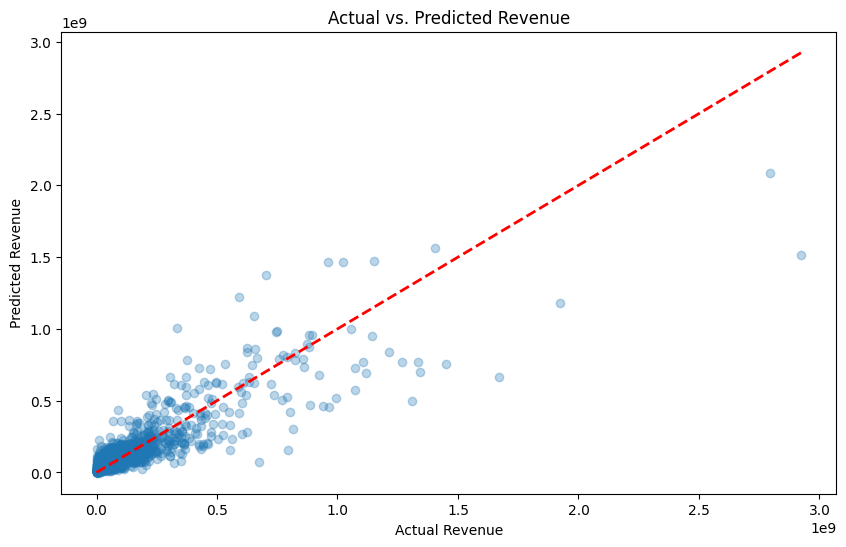

In [396]:
# Scatter Plot with Line of Equality
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs. Predicted Revenue')
plt.show()

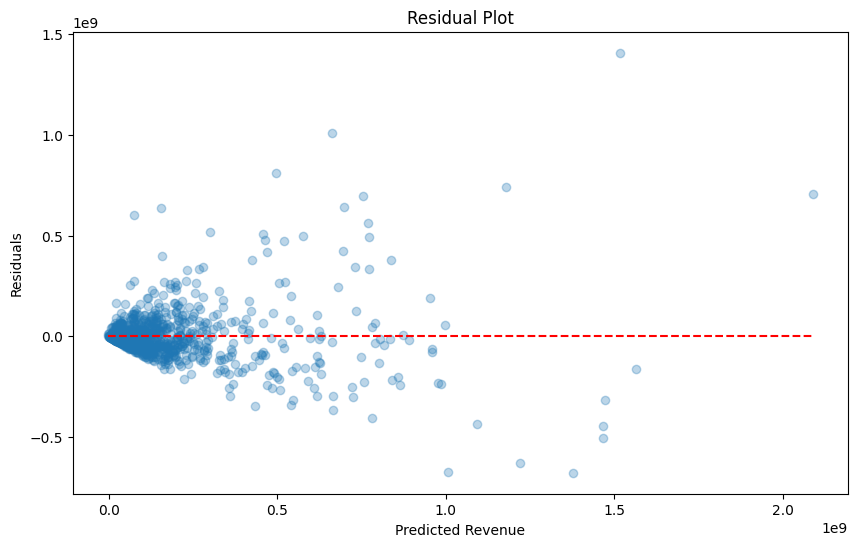

In [397]:
# Residual Plot
plt.figure(figsize=(10, 6))
residuals = y_test - xgb_y_pred
plt.scatter(xgb_y_pred, residuals, alpha=0.3)
plt.hlines(0, xmin=xgb_y_pred.min(), xmax=xgb_y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

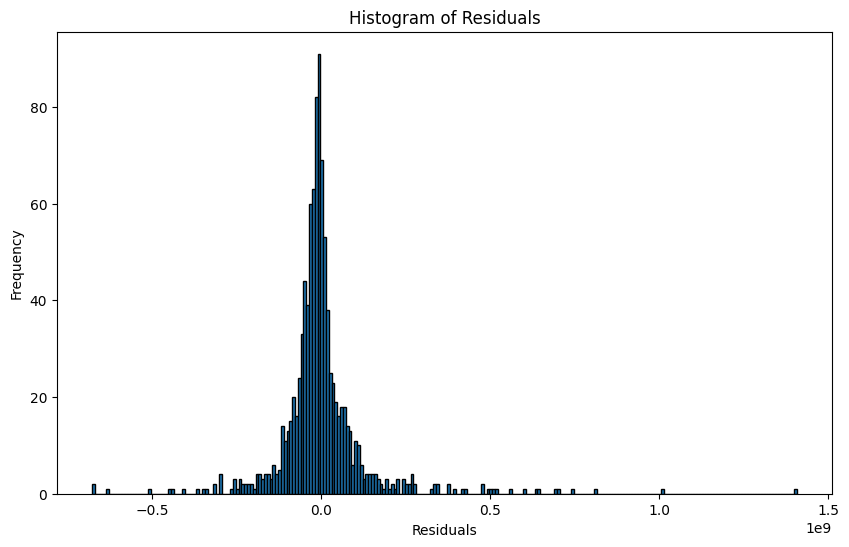

In [398]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=250, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

This is not quite what I would want to see for performance, there's some pretty heavy outliers, and I would want a stronger correlation with the actual revenue. This model could use some reworking.

### Notes

Findings development: 1 hour.